# Adaptive Waveform Inversion as Extended Source Inversion

## Overview

Adaptive Waveform Inversion (AWI) is (in some ways) similar to the approach we worked out to the single trace transmission problem. It is based on an extension that's like one single trace transmission for every source-receiver pair: that is, every such pair gets its own wavelet, and the goal is to concentrate the wavelet near $t=0$ as much as possible. There are several notable differences. First, AWI presumes that a "true" wavelet, that generates the data, is known. So it's possible to focus on an "adaptive" kernel that produces the extended wavelet by convolution with the known "true" wavelet. This adaptive kernel really should be $\delta(t)$ at the correct model, so multiplication by $t$ is really an annihilator, without having to make a "small support" assumption. We could have done this as well, but of course we got an estimate of the wavelet for our trouble, without having to assume a known "true" wavelet. Second, AWI deals with multidimensional models, and many traces, not just one. 

There is some understanding to be gained by applying the methodology we developed to this larger scale problem. First, I'll review AWI as it is presented in the literature, along with a computational approach that makes it practical and an example. Next comes recasting AWI into the penalty form that we used in studying the single trace transmission problem, and a re-interpretation of a normalization as a preconditioner. Applied to transmission problems, I believe that AWI is not immune from stagnation at useless estimates - that was the motivation for Surface Source Extension inversion, which is a generalization. Finally, I do not believe that any of these techniques are any better than FWI when applied to reflection data. So there are two interesting negative results to be had. However we will also be able to explain exatly why AWI works, when it does work.

 ## Warner-Guasch formulation of AWI
 
The version of AWI introduced by Michael Warner and Lluis Guasch (SEG 2014 and *Geophysics* 2016) assumes that seismic waves are governed by linear acoustics, and that each shot is associated to an isotropic point source with known location and wavelet. That is, the pressure and velocity fields $p({\bf x},t;{\bf x}_s)$, ${\bf v}({\bf x},t;{\bf x}_s)$ for the shot location ${\bf x}_s$ depend on the bulk modulus $\kappa({\bf x})$, buoyancy $\beta({\bf x})$ (reciprocal of the density $\rho({\bf x})$), and wavelet $w(t;{\bf x}_s)$ through the acoustic system
 $$
 \frac{\partial p}{\partial t} = - \kappa \nabla \cdot {\bf v} +
w(t;{\bf x}_s) \delta({\bf x}-{\bf x}_s);
\frac{\partial {\bf v}}{\partial t} = - \beta \nabla p; 
p, {\bf v} = 0 \mbox{ for }  t \ll 0.
$$
For sake of brevity, define the model vector $m=(\kappa,\rho)$. The forward map or *modeling operator* is $F[m]w = \{p({\bf x}_r,t;{\bf x}_s)\}$, in which shot and receiver positions ${\bf x}_s, {\bf x}_r$ define the acquisition geometry.

For now, assume that the data $d({\bf x}_r,t;{\bf x}_s)$ is the output of the modeling operator for "true" model $m_*$, that is, the "true" bulk modulus, buoyancy, and wavelet $\kappa_*, \beta_*, w_*$: that is, $d = F[m_*]w_*$.

The extended modeling operator ${\bar F}$ maps extended sources $\bar{w}({\bf x}_r,t;{\bf x}_s)$ to the same sampling of the pressure field. That is, the extended source depends on the receiver location as well as the source location - so there is one acoustic system for each source *and* receiver position - a lot of wave equations! If all of the wavelets for each source are the same, that is, ${\bar w}({\bf x}_r,t;{\bf x}_s) = w(t;{\bf x}_s)$ is independent of receiver position, then ${\bar F}[m]\bar{w} = F[m]w$. That is, $F$ is a special case, or restriction, of ${\bar F}$, so ${\bar F}$ is an extension of $F$. This is the *source-recever* extension, in the terminology of Huang et al. 2015. 

AWI assumes that the extended sources are time convolutions of the (known) exact source with a kernel $\bar{u}({\bf x}_r,t;{\bf x}_s)$: $\bar{w} = \bar{u} * w_*$ - the asterisk denotes convolution in time. Since linear acoustics is time-translation invariant, its solution commutes with time convolution, that is,
$$
\bar{F}[m]\bar{w} = \bar{F}[m](\bar{u} * w_*).
$$
With this set-up, the object of inversion can be formulated as:

Given $d$, find $m=(\kappa, \beta)$ and $\bar{w}$ so that $u({\bf x}_r,t;{\bf x}_s) = \delta(t)$ (so $\bar{w}=w_*$) and $\bar{F}[m]\bar{w} = F[m]w_* \approx d$. 

Warner and Guasch assume (implicitly) that there is always a (near-)zero-residual solution of the extended inversion problem. That is, they assume that for any $m$, there is a $\bar{w}$ for which $\bar{F}[m]\bar{w} \approx d$. If $\kappa \approx \kappa_*, \beta \approx \beta_*$, then $\bar{w}$ should be $\approx w_*$, so the adaptive kernel $\bar{u}$ should be approximately $\delta(t)$ and independent of ${\bf x}_s,{\bf x}_r$. Such a $\bar{u}$ is (approximately) in the null space of multiplication by $t$. Thus a first version of the AWI algorithm:

1. Given $m$, solve the problem $\bar{F}[m]\bar{w} = d$ for $\bar{w}$. 
2. Deconvolve $w_*$ from $\bar{w}$ to obtain $\bar{u}$ for which $\bar{w}=u * w_*$. 
3. Compute the objective 
$$
J_[m] = \int dx_s dx_r \left(\frac{\int dt |t\bar{u}|^2}{\int dt |\bar{u}|^2}\right)
$$
and its gradient, then update $\kappa,\beta$ by some gradient descent method. (The role of the normalization per source and receiver by the $L^2$ norm of $\bar{u}$ will be explained later.)

There are two things wrong with this algorithm. First, it involves way too many wave equation solves. Second, it depends on the assumption that you can fit the data exactly (which may or may not be the case, see examples to follow). Warner and Guasch fix the first problem. The second is fundamental, as will be shown below.

To solve the first problem, observe that the extended pressure field $\bar{p}$ is the convolution of the Green's function $G[m]$ (solution of the acoustic system above with $w(t,{\bf x}_s) = \delta(t)$) with the source function $w(t,{\bf x}_s)$. Since this source function is independent of the receiver position, only one wave equation needs to be solved for each source position, same as for non-extended modeling. Accordingly,
$$
\bar{F}[m]\bar{w} = G * \bar{w}
$$
Convolution is far cheaper than wave equation solve: thus the cost of computing the forward map is reduced to one wave equation solve per source, and one convolution per source and receiver.

On top of that, denote the convolution inverse of $G$ by $\check{G}$, and the convolution inverse of $w_*$ by $\check{w_*}$. Neither of these things may actually have a convolution inverse, strictly speaking. A solution of a regularized least-squares problem can play the same role. However these things are also cheaply approximated via discrete Fourier transform, which is what Warner and Guasch do. 

Then
$$
\bar{w} = \check{G} * d, \bar{u} =  \check{w_*}*\bar{w} = \check{w_*}*\check{G}*d
$$
and the first two steps in the above AWI algorithm can be replaced by inexpensive convolutions. This is the second version of the AWI algorithm. It is inexpensive enough to be employed on 3D data at field scale.

## Example, part 1

To begin with, let's show that the source-receiver extension, really is an extension. First create model and data as in the "Python interface to IWAVE" notebook. The bulk modulus has a somewhat weaker acoustic lens than the example in that notebook. The same point-source bandpass wavelet generates a pressure gather over 201 receivers spaced 20 m apart. 

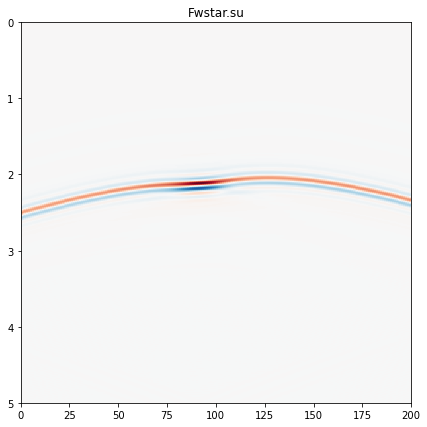

simplot: data min = -7.3255e-06, data max = 8.6175e-06


In [1]:
import linalg
import op
import data

# bulk modulus with less focussing lens
data.model(bulkfile='m.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20, lensfac=0.7)
# bandpass filter source at sx=4200, sz=3000 (single trace)
data.bpfilt(file='wstar.su',nt=251,dt=8.0,s=1.0,f1=1.0,f2=2.5,f3=7.5,f4=12,sx=4200,sz=3000)
# create zero data file with same source position, rz=500, rx=[2000,6000]
data.rechdr(file='g.su',nt=626,dt=8.0,rxmin=2000,rxmax=6000,ntr=201,rz=1000,sx=4200,sz=3000)
# copy onto output data file
linalg.copy('g.su','Fwstar.su')
# apply fd operator
op.fdop(m='m.rsf', w='wstar.su', d='Fwstar.su')
# plot
linalg.simplot('Fwstar.su')

To see that d = F[m]w_* is also the result of extended modeling, create a Green's function for the source and reciever positions - this requires a zero-phase delta function at the correct location.

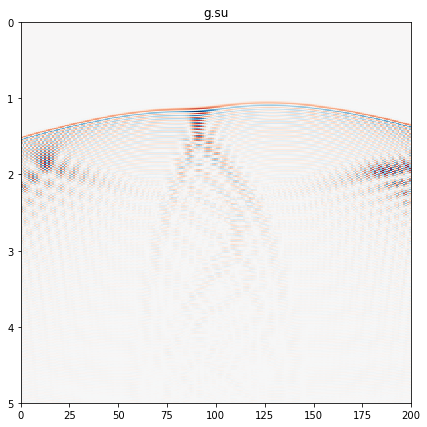

simplot: data min = -3.3352e-05, data max = 3.0076e-05


In [2]:
import linalg
import op
import data

# create delta function at sx=4200, sz=3000 
data.delta(file='delta.su', nt=201, dt=8.0, sx=4200, sz=3000)
# apply fd op - since won't need prototype header file any more, 
# overwrite with green's fucntion
op.fdop(m='m.rsf',w='delta.su',d='g.su')
# take a look
linalg.simplot('g.su')

Create an extended source, replicating the bandpass filter for each trace (receiver position) by 

1. creating an extended source gather with the same source/receiver locations as the data, the same time range and step as the single-trace bandpass filter 
2. creating a delta function gather with the same source/receiver locations as the data, but the same time range and step as the single-trace delta function
3. convolve the each trace of the delta gather with the (single-trace) bandpass filter. The delta gather plays the role of the green's function, the extended source gather plays the role of the output data, the single-trace bandpass filter is the source.

This replicates the bandpass filter at each source/receiver locati


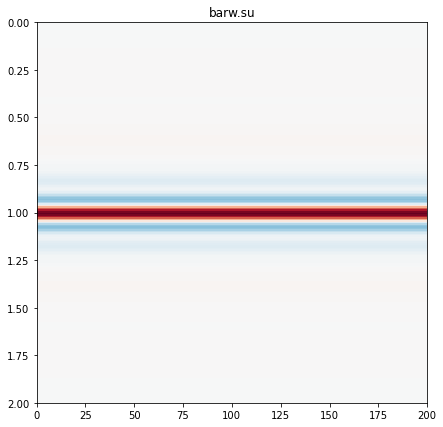

simplot: data min = -6.6359e-03, data max = 1.5873e-02


In [3]:
import linalg
import op
import data

# extended source headers
data.rechdr(file='barw.su',nt=251,dt=8.0,rxmin=2000,rxmax=6000,ntr=201,rz=1000,sx=4200,sz=3000)
# extended delta gather
data.deltagather('bardelta.su',nt=201,dt=8.0,ntr=201,sxstart=2000,szstart=6000,dsx=20,dsz=0)
# convolve
op.convop(g='bardelta.su',w='wstar.su',d='barw.su',adj=0)
# plot
linalg.simplot('barw.su')

To apply $\bar{F}[m]$, simply use *the same* Green's function as used in convolutional modeling, but with an extended source, that is, a gather of source traces, one per receiver position. barw.su is such a gather. The function op.convop(g,w,d,adj) is set up to recognize automatically that there is one input trace per receiver (that is, on trace per trace in the Green's function) and perform the correct convolution, writing the result to the output trace

In this case, barw.su is the extended source that produces the same output as the single-trace source wstar.su:

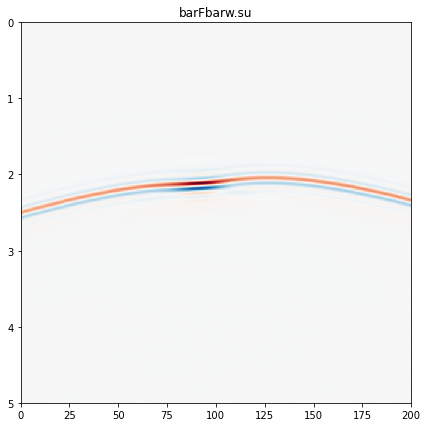

simplot: data min = -7.3256e-06, data max = 8.6175e-06
norm of barFbarw.su - Fwstar.su = 2.9438e-07
relative error = 5.8399e-04


In [4]:
import linalg
import op

linalg.copy('g.su','barFbarw.su')
op.convop(g='g.su',w='barw.su',d='barFbarw.su',adj=0)
linalg.simplot('barFbarw.su')
linalg.copy('barFbarw.su','diffbarFbarw.su')
linalg.lincomb(-1.0,'Fwstar.su','diffbarFbarw.su')
dnorm = linalg.norm('Fwstar.su')
diffnorm = linalg.norm('diffbarFbarw.su')
print('norm of barFbarw.su - Fwstar.su = %10.4e' % (diffnorm))
print('relative error = %10.4e' % (diffnorm/dnorm))


## Least squares formulation
Recall the convolutional representation of $\bar{F}$:
$$
\bar{F}[m]\bar{w} = G[m] * \bar{w}
$$
also the relation between the adaptive kernel $\bar{u}$, (known) source wavelet $w_*$, and extended source $\bar{w}$: 
$$
\bar{w} = \bar{u} * w_*
$$
Putting these together and using the commutativity of convolution,
$$
\bar{F}[m]\bar{w} = (G[m] * w_*) * \bar{u} = (F[m]w_*)*\bar{u} 
$$
In other words, the predicted *non-extended* data $F[m]w_*$ is the convolution kernel mapping the adaptive kernel $\bar{u}$ to predicted *extended* data $\bar{F}[m]\bar{w}$. 

This observation suggests reformulating the inverse problem directly in terms of the adaptive kernel $\bar{u}$: that is, find $\bar{u}$ so that
$$
\bar{S}[m,w_*]\bar{u} \equiv (F[m]w_*)*\bar{u} = \bar{F}[m](\bar{u}*w_*)
$$
approximates the data. Here $\bar{S}[m,w_*]$ is the operator of convolution with the *non-extended* predicted data $F[m]w_*$.

The straightforward least squares formulation would be: given $m, w_*, d$, find $\bar{u}$ to minimize (approximately)
$$
J_0[m,\bar{u};w_*,d] = \|\bar{S}[m,w_*]\bar{u}-d\|^2
$$
Here is an approximate minimizer $\bar{u}$ of this problem, computed via conjugate gradient iteration: 

----------------------------------------------------
  k       |e|     |e|/|e0|      |r|        |r|/r0|
 19  1.5828e-05  3.1400e-02  1.7787e-09  9.5023e-03


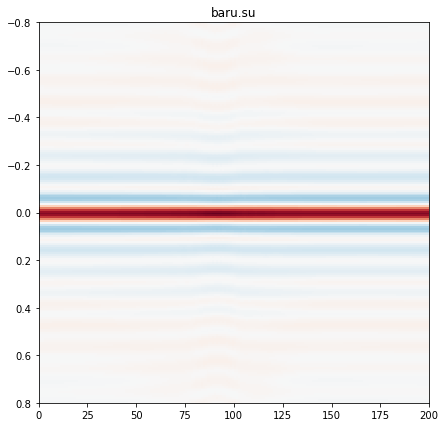

simplot: data min = -7.6037e-03, data max = 2.1225e-02


In [5]:
import linalg
import cg0

linalg.copy('bardelta.su','baru.su')

kmax=50
eps=0.01
rho=0.01
w='baru.su'
d='Fwstar.su'
g='FWstar.su'
e='e.su'
r='r.su'

cg0.conjgrad0(w, d, g, kmax, eps, rho, e, r, verbose=1)

linalg.simplot('baru.su')

The waveform is perfectly symmetric, independent of receiver location (trace index), and more focused at $t=0$ than the extended source barw.su, plotted above. Convolving baru.su with wstar.su would produce a close approximation of barw.su.

The relative error is about 3%. The iteration terminated because the normal residual error dropped below 1%. 

The next hypothesis to test is whether the extended model can fit the data well for any model $m$, correct or not. For example, we could use a constant bulk modulus $\kappa=4.0$, rather than the field with the lens that created the data Fwstar.su. 

----------------------------------------------------
  k       |e|     |e|/|e0|      |r|        |r|/r0|
 26  5.0216e-06  9.9619e-03  2.8763e-10  2.0996e-03


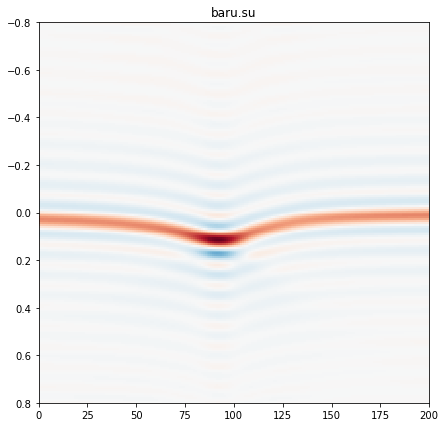

simplot: data min = -2.1308e-02, data max = 4.2524e-02


In [6]:
import linalg
import data
import op
import cg0

# homog bulk modulus with 
data.model(bulkfile='m0.rsf', bulk=4.0, nx=401, nz=201, dx=20, dz=20, lensfac=1.0)

# compute non-extended predicted data d0
linalg.copy('Fwstar.su', 'd0.su')
op.fdop(m='m0.rsf', w='wstar.su', d='d0.su')

linalg.copy('bardelta.su','baru.su')

kmax=200
eps=0.01
rho=0.00
w='baru.su'
d='Fwstar.su'
g='d0.su'
e='e.su'
r='r.su'

cg0.conjgrad0(w, d, g, kmax, eps, rho, e, r, verbose=1)

linalg.simplot('baru.su')